In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import numpy as np

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

import torch.nn.functional as F
import torch_scatter
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv
import math
from matplotlib import pyplot as plt
from itertools import combinations

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using {}".format(device))

Using cpu


In [2]:
data = np.load("dataset.npz")
X_loaded = torch.Tensor(data["X"]).to(device) #shape N, 20, 2 N = 10000
Y_loaded = torch.Tensor(data["Y"]).to(device) #shape N, 20, 20

In [15]:
#define custom dataset and data loader
class GraphDataSet(Dataset):
    def __init__(self, X_data, Y_data):
        self.X_data = X_data
        self.Y_data = Y_data

    def __len__(self):
        return self.X_data.shape[0]

    def __getitem__(self, index):
        return (self.X_data[index], self.Y_data[index])

train_dataset = GraphDataSet(X_loaded, Y_loaded)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [4]:
def plot_graph(x: torch.Tensor, adj: torch.Tensor):
    """
    Plots a 2D graph based on node coordinates and an adjacency matrix.

    Args:
        x (torch.Tensor): Tensor of shape (N, 2), where each row is a 2D coordinate.
        adj (torch.Tensor): Tensor of shape (N, N), adjacency matrix.
    """
    x = x.cpu().numpy()
    adj = adj.cpu().numpy()
    num_nodes = x.shape[0]

    plt.figure(figsize=(6, 6))

    # Plot edges
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):  # avoid plotting both (i,j) and (j,i)
            if adj[i, j] != 0:
                x_coords = [x[i, 0], x[j, 0]]
                y_coords = [x[i, 1], x[j, 1]]
                plt.plot(x_coords, y_coords, 'k-', linewidth=0.5)  # edge as black line

    # Plot nodes
    plt.scatter(x[:, 0], x[:, 1], c='blue', s=30, zorder=3)

    for i in range(num_nodes):
        plt.text(x[i, 0], x[i, 1], str(i), fontsize=8, ha='center', va='center', color='white',
                 bbox=dict(facecolor='blue', edgecolor='none', boxstyle='circle,pad=0.2'))

    plt.title("Graph Visualization")
    plt.axis('equal')
    plt.grid(True)
    plt.show()

In [5]:
def build_knn_edges_batched(points_batch, k):
    """
    Vectorized batched KNN edge construction.

    Args:
        points_batch: Tensor of shape (B, N, 2)
        k: int, number of neighbors

    Returns:
        edge_index: Tensor of shape (2, total_edges)
        batch: Tensor of shape (B * N,) each element indicates which batch element each edge belongs to 
    """
    B, N, _ = points_batch.shape
    device = points_batch.device

    # (B, N, N) pairwise distances
    dists = torch.cdist(points_batch, points_batch, p=2.0)

    # Get top-k neighbors (exclude self, so take 1:k+1)
    _, knn_idx = torch.topk(dists, k=k + 1, dim=-1, largest=False)  # shape: (B, N, k+1)
    knn_idx = knn_idx[:, :, 1:]  # remove self

    # Build source and target indices for edges
    src = torch.arange(N, device=device).view(1, N, 1).repeat(B, 1, k)  # (B, N, k)
    tgt = knn_idx  # (B, N, k)

    # Batch offset
    batch_offset = (torch.arange(B, device=device) * N).view(B, 1, 1)
    src = (src + batch_offset).reshape(-1)
    tgt = (tgt + batch_offset).reshape(-1)

    # Symmetrize: add both (i, j) and (j, i)
    edge_index = torch.cat([torch.stack([src, tgt], dim=0),
                            torch.stack([tgt, src], dim=0)], dim=1)  # (2, 2*B*N*k)

    return edge_index

def make_pyg_batch_2dpoints(points_batch, k):
    """
    Args:
        points_batch: (B, N, 2)
        k: int

    Returns:
        PyG Batch object with:
            - x: shape (B*N, 2) <-- stacked 2d coordinates of all nodes
            - edge_index: shape (2, total_edge) <-- stacked edge list, first row starting node, second row ending node
            - batch: shape (B*N,), indicating which graph each node belongs to
    """
    B, N, _ = points_batch.shape
    device = points_batch.device

    # Build edge_index (2, E)
    edge_index = build_knn_edges_batched(points_batch, k)

    # Flatten all points into (B*N, 2)
    x = points_batch.reshape(B * N, 2)

    # Build batch vector
    batch = torch.arange(B, device=device).repeat_interleave(N)  # (B*N,)

    return Batch(x=x, edge_index=edge_index, batch=batch)


class SimpleGNN(nn.Module):
    '''
    A simple GCN that only updates node embeddings.
    Incorporates batch info (even if it doesn't feed it directly to GCNConv).
    '''
    def __init__(self, in_dim=2, hidden_dim=32, num_layers=2):
        super().__init__()
        self.convs = nn.ModuleList()
        cur_dim = in_dim
        for _ in range(num_layers):
            self.convs.append(GCNConv(cur_dim, hidden_dim))
            cur_dim = hidden_dim
        self.out_dim = hidden_dim
        
    def forward(self, data_batch):
        """
        data_batch is a PyG Data (or DataBatch) with:
          - data_batch.x: (total_nodes, in_dim)  node features
          - data_batch.edge_index: (2, E)        adjacency
          - data_batch.batch: (total_nodes,)     subgraph ID for each node
        returns:
          node_emb: (total_nodes, hidden_dim)
        """
        x, edge_index, batch = data_batch.x, data_batch.edge_index, data_batch.batch

        # Even though GCNConv doesn't directly need `batch`,
        # we keep it so PyG is aware these nodes belong to multiple subgraphs.
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
        return x


class EdgeMLP(nn.Module):
    """
    For a batch of graphs, each with N nodes, produce a probability adjacency matrix A of size (B, N, N).
    - B is the batch size
    - N is the number of nodes per graph
    - node_emb: (B*N, embed_dim)
    - data_batch.batch: (B*N,) indicates subgraph membership (0..B-1)
    """

    def __init__(self, embed_dim=32, hidden_dim=64):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    @staticmethod
    def pair_node_embeddings(H, B, N):
        """
        H: Tensor of shape (B*N, hidden_dim)
        Returns: Tensor of shape (B*N*(N-1)/2, 2*hidden_dim)
        """
        hidden_dim = H.shape[1]
        H = H.view(B, N, hidden_dim)  # (B, N, hidden_dim)
    
        # Create all index pairs (i, j) where i < j
        idx_pairs = list(combinations(range(N), 2))  # [(0,1), (0,2), (1,2), ...]
        idx_i = torch.tensor([i for i, j in idx_pairs])
        idx_j = torch.tensor([j for i, j in idx_pairs])
    
        # Expand to batch dimension
        idx_i = idx_i.unsqueeze(0).repeat(B, 1)  # (B, num_pairs)
        idx_j = idx_j.unsqueeze(0).repeat(B, 1)  # (B, num_pairs)
        batch_indices = torch.arange(B).unsqueeze(1).repeat(1, len(idx_pairs))  # (B, num_pairs)
    
        # Gather embeddings
        h_i = H[batch_indices, idx_i]  # (B, num_pairs, hidden_dim)
        h_j = H[batch_indices, idx_j]  # (B, num_pairs, hidden_dim)
    
        # Concatenate
        h_cat = torch.cat([h_i, h_j], dim=-1)  # (B, num_pairs, 2*hidden_dim)
        h_cat = h_cat.view(-1, 2 * hidden_dim)  # (B*num_pairs, 2*hidden_dim)
        return h_cat

    @staticmethod
    def build_batched_adj_matrix(batched_prob, B, N):
        """
        batched_prob: Tensor of shape (B * num_pairs, 1)
        Returns: Tensor of shape (B, N, N) - symmetric adjacency matrices with 0 diagonals
        """
        device = batched_prob.device
        batched_prob = batched_prob.view(B, -1)  # (B, num_pairs)
        
        # Get upper triangle indices (i < j)
        idx_pairs = list(combinations(range(N), 2))  # [(0,1), (0,2), (1,2), ...]
        idx_i = torch.tensor([i for i, j in idx_pairs], device=device)
        idx_j = torch.tensor([j for i, j in idx_pairs], device=device)
        
        # Initialize empty adjacency matrix
        adj = torch.zeros((B, N, N), device=device)
    
        # Fill the upper triangle
        adj[:, idx_i, idx_j] = batched_prob
    
        # Symmetrize (copy upper to lower)
        adj = adj + adj.transpose(1, 2)
    
        return adj
    
    def forward(self, node_emb, B, N):
        """
        Args:
            node_emb: (B*N, embed_dim)  stacked embeddings of all graphs in the batch
            batch:    (B*N,)           subgraph index for each node (range 0..B-1)
        
        Returns:
            A: (B, N, N) adjacency probability matrix for each graph.
               - A[b] is the NxN adjacency matrix for graph b.
               - A[b, i, j] = P(edge between node i, j in graph b)
               - diagonal set to 0
               - matrix is symmetrized
        """
        H_paired = self.pair_node_embeddings(node_emb, B, N) #shape (B*N*(N-1)/2, 2*hidden_dim)
        #go through the MLP
        batched_prob = self.mlp(H_paired) #shape (B*N*(N-1)/2, 1)
        batched_adj = self.build_batched_adj_matrix(batched_prob, B, N) 
        return batched_adj
        
#Combine everything
class GraphEdgePredictor(nn.Module):
    def __init__(self, k=5, gnn_hidden=32, gnn_layers=2):
        super().__init__()
        self.k = k
        self.gnn = SimpleGNN(in_dim=2, hidden_dim=gnn_hidden, num_layers=gnn_layers)
        self.edge_mlp = EdgeMLP(embed_dim=gnn_hidden, hidden_dim=64)

    def forward(self, batch_points):
        """
        batch_points: shape (B, N, 2)
          1) create a list of PyG Data for each sample
          2) batch them into one big Data
          3) do GNN => node embeddings
          4) for each subgraph, compute adjacency probabilities 
             for all i<j
          => return adjacency (B, N, N)
        """
        B, N, _ = batch_points.shape
        
        #build PYG data
        data_batch = make_pyg_batch_2dpoints(batch_points, self.k)
        #go through the convGNN to obtain node embedding
        H = self.gnn(data_batch) #shape (B*N, hidden_dim)
        #go through the MLP to obtain the adj matrix
        A = self.edge_mlp(H, B, N)
        return A

In [8]:
##custom loss function 

#this is the binary cross entropy between prediction and reference 
def adjacency_bce_loss(pred_adj, ref_adj, weight=1.0):
    """
    pred_adj: (B, N, N) with predicted probabilities in [0,1].
    ref_adj:  (B, N, N) with 0/1 ground truth. 
              symmetrical and diagonal=0.
    Return: scalar loss.
    """
    B, N, _ = pred_adj.shape
    # mask for upper triangle, excluding diagonal
    # shape => (N,N), boolean
    triu_mask = torch.triu(torch.ones(N, N), diagonal=1).bool().to(pred_adj.device)
        
    # gather the predicted upper triangle => shape (B, #tri_entries)
    pred_upper = pred_adj[:, triu_mask]
    # gather the reference upper triangle => shape (B, #tri_entries)
    ref_upper = ref_adj[:, triu_mask].float()
        
    # use a BCE loss (or BCEWithLogitsLoss if you want the logits directly)
    bce = nn.BCELoss(reduction='none')
    loss = bce(pred_upper, ref_upper)# shape (B, #tri_entries)
    
    #add more weights on false negative prediction 
    false_neg_mask = (ref_upper == 1) & (pred_upper < 0.5)
    weights = torch.ones_like(loss)
    weights[false_neg_mask] = weight #weight false negatives more
    
    weighted_loss = (weights * loss).mean()

    return weighted_loss

def unconnected_node_loss(pred_adj, thres=0.5):
    B, N, _ = pred_adj.shape
    adj = pred_adj > thres
    return ((adj.sum(axis=1) < 3).sum(axis=1)/N).sum()/B

#this loss is the MSE between predicted edge numbers and reference edge number
def MSE_edge_num(pred_adj, ref_adj, thres=0.5):
    pred_edge_num = (pred_adj > thres).sum(axis=(1, 2))
    ref_edge_num = ref_adj.sum(axis=(1, 2))
    return torch.nn.MSELoss()(pred_edge_num, ref_edge_num)

In [9]:
learning_rate = 2e-4
model = GraphEdgePredictor(k=8, gnn_hidden=64, gnn_layers=4).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_trace = []; bce_loss_trace = []; unconnected_penalty_trace = []
epochs = 50
for i in tqdm(range(epochs)):
    #pass through all the data
    for x, y in train_loader:
        #forward pass
        predict = model(x)
        #compute the loss
        bceloss = adjacency_bce_loss(predict, y, weight=4.0)
        unconnected_penalty = unconnected_node_loss(predict)
        edge_num_loss = MSE_edge_num(predict, y)
        loss = bceloss + unconnected_penalty + 0.1*edge_num_loss
    
        #backward pass and optimization 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_trace.append(loss.item())
        bce_loss_trace.append(bceloss.item())
        unconnected_penalty_trace.append(unconnected_penalty.item())

  0%|          | 0/50 [00:00<?, ?it/s]

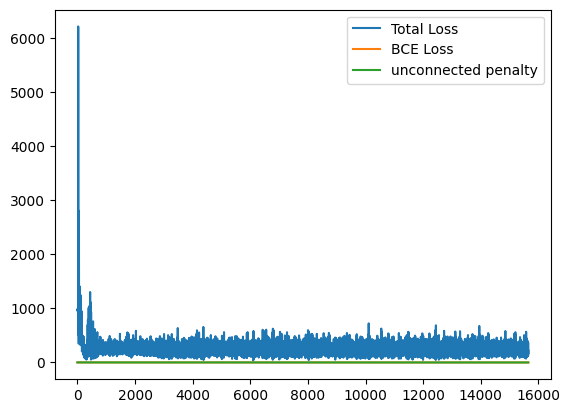

In [14]:
plt.plot(loss_trace, label="Total Loss");
plt.plot(bce_loss_trace, label='BCE Loss');
plt.plot(unconnected_penalty_trace, label='unconnected penalty');
plt.legend();

In [11]:
pred_matrix = (model(x) > 0.5)*1

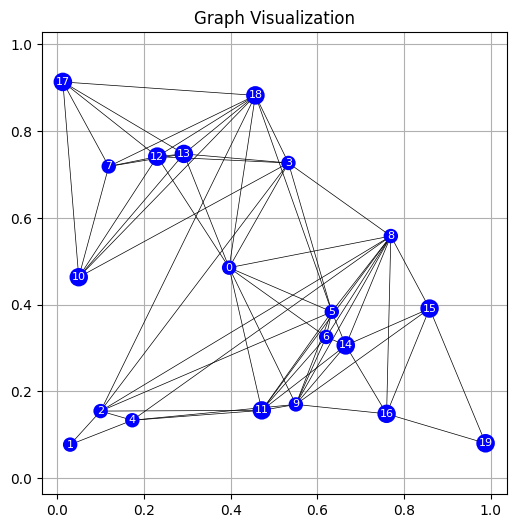

In [12]:
plot_graph(x[1], pred_matrix[1])

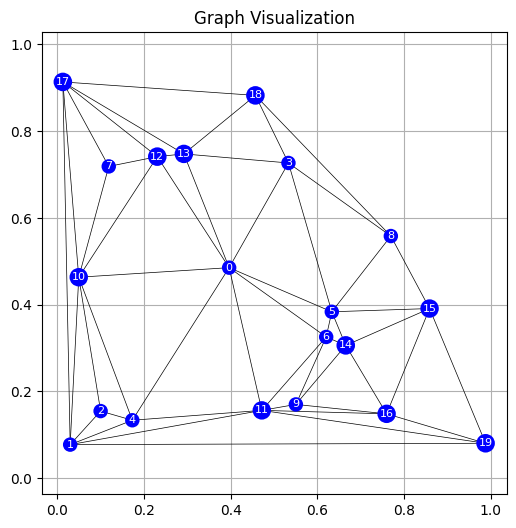

In [13]:
plot_graph(x[1], y[1])